# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning - Project
---

## "Mind the Gap" - A Deep Learning Analysis of Pothole Detection
---

|      Name    |      Campus Email              | Personal Email        |
|--------------|--------------------------------|-----------------------|
|Itai Benyamin | itai.b@campus.technion.ac.il         |itai.benyamin@gmail.com|
|Idan Baruch   | idan-b@campus.technion.ac.il|idanb12200@gmail.com  |

## Introduction


In [22]:
import os
import shutil
import xmltodict
import random
import numpy as np
import pandas as pd
import cv2
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
from torchmetrics.detection import MeanAveragePrecision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub as kh

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pin_memory = True if device == "cuda:0" else False

print("pytorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch built with CUDA:", torch.backends.cuda.is_built())
print("Available devices:", torch.cuda.device_count())
print("Current device:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No device")

pytorch version: 2.5.1
torchvision version: 0.20.1
Is CUDA available: True
CUDA version: 11.8
PyTorch built with CUDA: True
Available devices: 1
Current device: NVIDIA GeForce RTX 3090


## Part 1 - Data Loading

In [23]:
kaggle_datapath = 'andrewmvd/pothole-detection'
if not os.path.exists('data'):
    #Load the data from kaggle
    data_path = kh.dataset_download(kaggle_datapath)
    # Move the data to the correct location
    shutil.move(data_path, 'data')
else:
    print('Data already exists')

Data already exists


In [24]:
class PotholeDetectionDataset:
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        #self.img_files = sorted(os.listdir(img_dir), key=self._extract_index)
        #self.ann_files = sorted(os.listdir(ann_dir), key=self._extract_index)
        self.transform = transform
        
        # Preprocess data
        self.img_files, self.ann_files = self._preprocess_dataset()

    
    @staticmethod
    def _extract_index(filename):
        # Use a regex to extract the numeric index from the file name
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')

    def _preprocess_dataset(self):
        # Get images from folder
        img_files = sorted(os.listdir(self.img_dir), key=self._extract_index)
        ann_files = sorted(os.listdir(self.ann_dir), key=self._extract_index)

        valid_img_files = []
        valid_ann_files = []

        # Parse images and annotated boxes to return only the valid images and boxes
        for img_file, ann_file in zip(img_files, ann_files):
            img_path = os.path.join(self.img_dir, img_file)
            ann_path = os.path.join(self.ann_dir, ann_file)
            
            # Load and validate
            img = cv2.imread(img_path)
            img_height, img_width = img.shape[:2]
            boxes = self.parse_voc_annotation(ann_path)
            
            if self._check_boxes_validity(boxes, img_width, img_height):
                valid_img_files.append(img_file)
                valid_ann_files.append(ann_file)
        
        return valid_img_files, valid_ann_files
    
    @staticmethod
    def _check_boxes_validity(boxes, img_width, img_height):
        for xmin, ymin, xmax, ymax in boxes:
            width = xmax - xmin
            height = ymax - ymin
            
            if width <= 0 or height <= 0:
                return False
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                return False
        return True

    def parse_voc_annotation(self, ann_path):
        with open(ann_path) as f:
            ann_data = xmltodict.parse(f.read())
        
        boxes = []
        objects = ann_data["annotation"].get("object", [])
        if not isinstance(objects, list):
            objects = [objects]
        
        for obj in objects:
            bbox = obj["bndbox"]
            xmin = int(float(bbox["xmin"]))
            ymin = int(float(bbox["ymin"]))
            xmax = int(float(bbox["xmax"]))
            ymax = int(float(bbox["ymax"]))
            boxes.append((xmin, ymin, xmax, ymax))
        
        return boxes
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]  # (height, width)
        
        # Load annotations
        boxes = self.parse_voc_annotation(ann_path)
        
        # Apply transform
        if self.transform is not None:
            img_pil = torchvision.transforms.ToPILImage()(img)
            img = self.transform(img_pil)
            new_size = (img.shape[2], img.shape[1])  # (width, height)
            
            # Adjust bounding boxes
            orig_h, orig_w = original_size
            new_w, new_h = new_size
            x_scale = new_w / orig_w
            y_scale = new_h / orig_h
            boxes = [
                (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
                for xmin, ymin, xmax, ymax in boxes
            ]
        
        return img, boxes, idx
    
# custom collate_fn for torch DataLoader
def collate_fn(batch):
    images = [item[0] for item in batch]  # List of images
    boxes = [item[1] for item in batch]  # List of bounding boxes
    indices = [item[2] for item in batch]  # List of indices
    return images, boxes, indices

In [25]:
# Paths to images and annotations
img_dir = "./data/images"
ann_dir = "./data/annotations"

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((480, 480)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
])

# Initialize the dataset
dataset = PotholeDetectionDataset(img_dir, ann_dir, transform=transform)

# Split the dataset to train, validation, and test sets (70-10-20)
#train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=seed)
#train_set, val_set = train_test_split(train_set, test_size=0.125, random_state=seed)

# Maintain the original indices while splitting
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.125, random_state=seed)

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

print(f"Train set size: {len(train_set)} - {len(train_set)/len(dataset)*100:.2f}%")
print(f"Validation set size: {len(val_set)} - {len(val_set)/len(dataset)*100:.2f}%")
print(f"Test set size: {len(test_set)} - {len(test_set)/len(dataset)*100:.2f}%")

Train set size: 463 - 69.83%
Validation set size: 67 - 10.11%
Test set size: 133 - 20.06%


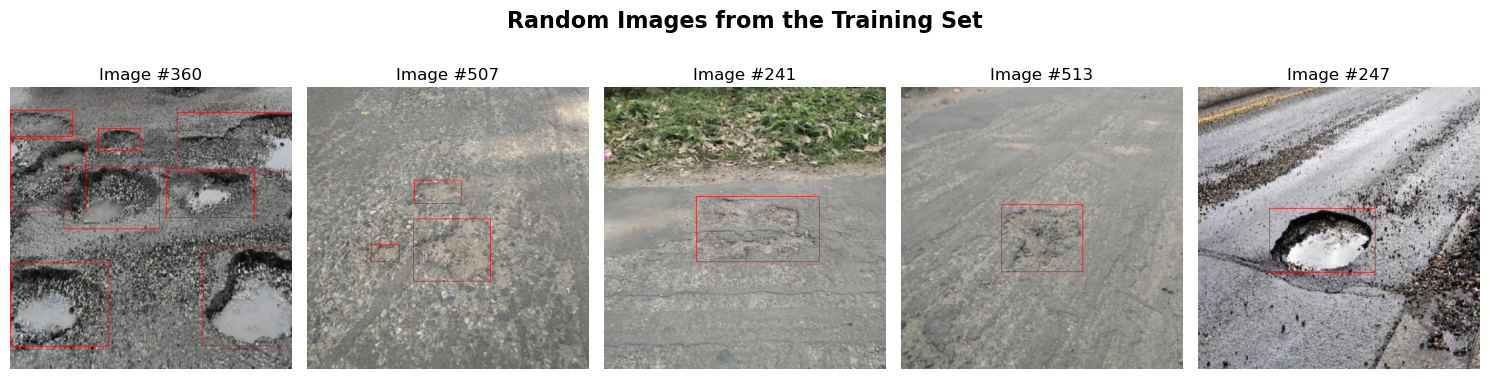

In [26]:
# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)
images, boxes, indices = next(iter(train_loader))

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, (img, bboxes, idx) in enumerate(zip(images, boxes, indices)):
    img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
    
    for box in bboxes:
        cv2.rectangle(img_np, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1)
    
    axs[i].imshow(img_np)
    axs[i].axis("off")
    axs[i].set_title(f"Image #{idx}")

# Add a main title
plt.suptitle("Random Images from the Training Set", fontsize=16, fontweight="bold", y=0.9)

plt.tight_layout()
plt.show()


## Part 2 - CNN

In [27]:
# Taking something from chat to verify installations.

# Define the dataset and DataLoader
train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_set,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a single-class output
num_classes = 2  # 1 class (pothole) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, boxes, batch_indices in train_loader:
        # Prepare inputs for the model
        images = [img.to(device) for img in images]
        targets = []
        for i, b in enumerate(boxes):
            targets.append({
                'boxes': torch.tensor(b, dtype=torch.float32, device=device),
                'labels': torch.ones((len(b),), dtype=torch.int64, device=device)  # Class 1 for potholes
            })
        
        # Compute loss
        try:
            loss_dict = model(images, targets)
        except AssertionError:
           print(f'Problematic index:{batch_indices}')
           #cv2.imshow() 
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Step the learning rate scheduler
    lr_scheduler.step()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "faster_rcnn_pothole.pth")
print("Model training complete. Saved as 'faster_rcnn_pothole.pth'.")

/home/user_138/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user_138/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 43.6472
Epoch 2/10, Loss: 29.2626
Epoch 3/10, Loss: 23.7847
Epoch 4/10, Loss: 17.6410
Epoch 5/10, Loss: 16.2644
Epoch 6/10, Loss: 15.2922
Epoch 7/10, Loss: 14.5486
Epoch 8/10, Loss: 14.3882
Epoch 9/10, Loss: 14.2789
Epoch 10/10, Loss: 14.2368
Model training complete. Saved as 'faster_rcnn_pothole.pth'.


/tmp/ipykernel_519653/700516302.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("faster_rcnn_pothole.pth"))


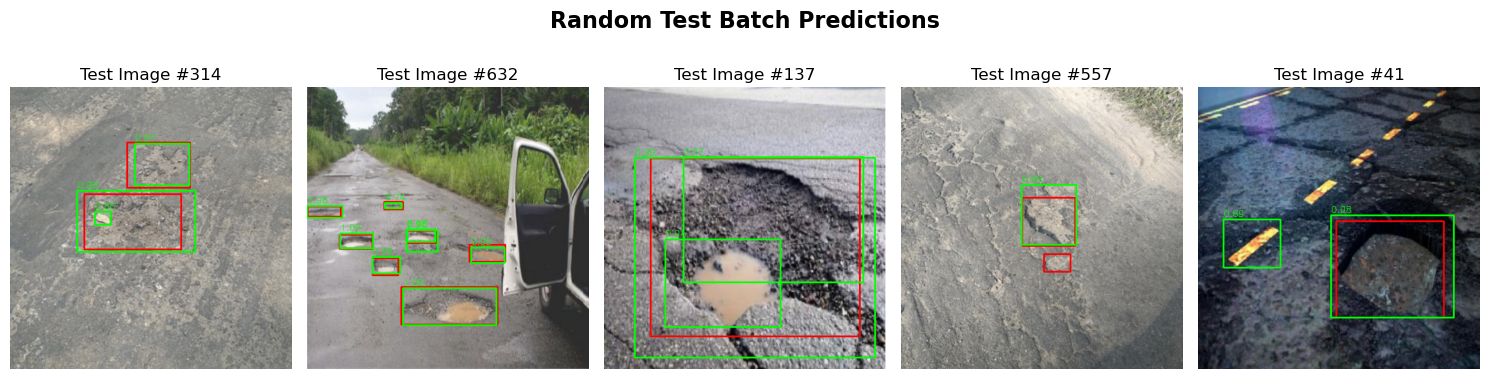

In [31]:
# Load the trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)  # 2 classes: background and pothole
model.load_state_dict(torch.load("faster_rcnn_pothole.pth"))
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# Define the TestLoader
test_loader = DataLoader(test_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

# Function to calculate test score (e.g., mean Average Precision)
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()  # Ensure the model is in evaluation mode
    all_predictions = {}
    all_ground_truths = {}
    
    with torch.no_grad():
        for batch_idx, (images, gt_boxes, indices) in enumerate(data_loader):
            # Prepare images for inference
            inputs = [img.to(device) for img in images]
            
            # Run model inference
            outputs = model(inputs)
            
            # Collect predictions and ground truth
            for i, (output, gt, idx) in enumerate(zip(outputs, gt_boxes, indices)):
                predictions = [
                    (box.tolist(), score.item())
                    for box, score in zip(output['boxes'], output['scores'])
                    if score >= threshold
                ]
                all_predictions[idx] = predictions
                all_ground_truths[idx] = gt
            
    return all_predictions, all_ground_truths

# Evaluate the model on the test set
all_predictions, all_ground_truths = evaluate_model(model, test_loader, threshold=0.5)

# Visualize a random test batch
random_batch = random.choice(list(test_loader))  # Select a random batch
images, boxes, indices = random_batch

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, (img, bboxes, idx) in enumerate(zip(images, boxes, indices)):
    img_np = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    img_np = (img_np * 255).astype(np.uint8).copy()  # Scale and convert to uint8
    
    # Draw ground truth boxes (blue)
    for box in bboxes:
        cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
    
    # Access predictions using the index directly
    predictions = all_predictions.get(idx, [])
    
    # Draw predictions (green)
    for pred_box, score in predictions:
        xmin, ymin, xmax, ymax = map(int, pred_box)
        cv2.rectangle(img_np, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    axs[i].imshow(img_np)
    axs[i].axis("off")
    axs[i].set_title(f"Test Image #{idx}")

# Add a main title
plt.suptitle("Random Test Batch Predictions", fontsize=16, fontweight="bold", y=0.9)

plt.tight_layout()
plt.show()

## Part 3 - ViT

## Part 4 - Smearing Noise

## Conclusions